<a href="https://colab.research.google.com/github/AKIYAMA-Keito/Colab-repo/blob/main/AWP_nondef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np

Step1 Tensorflowチュートリアル4から引用

version2


データセットを読み込んで正規化する．

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
random_index_train = np.array(range(len(x_train)))
np.random.shuffle(random_index_train)
x_train = x_train[random_index_train][:1000]
y_train = y_train[random_index_train][:1000]
x_train = x_train / 255.0
x_test = x_test/255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

データセットをシャッフルしてバッチ化する．

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).batch(1000)

CNNモデルを定義しインスタンスを取り出す．

In [4]:
class CNNModel(Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation = "relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = "relu")
        self.d2 = Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = CNNModel()

損失関数とoptmizerを選択する．

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

損失関数とoptimizerの尺度評価のための関数を導入する．

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

モデルを訓練するための関数train_stepを定義する．
予測値と正解ラベルの間の損失関数の勾配を最適化する．

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

モデルをテストするための関数test_stepを定義する．

In [8]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training = False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

学習を実行してテストし，結果を出力する．

In [9]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for train_images, train_labels in train_ds:
        train_step(train_images, train_labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 2.316840887069702, Accuracy: 9.800000190734863, Test Loss: 1.9483191967010498, Test Accuracy: 63.810001373291016
Epoch 2, Loss: 1.928775429725647, Accuracy: 67.29999542236328, Test Loss: 1.5128244161605835, Test Accuracy: 68.81999969482422
Epoch 3, Loss: 1.4787541627883911, Accuracy: 70.9000015258789, Test Loss: 1.1621321439743042, Test Accuracy: 77.02000427246094


AWPのアルゴリズムを記述する．
まず，学習済みのmodelから重みを取り出してvを加えて再設定する．

In [10]:
weights = model.get_weights()
ordinary_weights = weights
v_array = []
for w in weights:
  v = 0.00002 * np.random.rand() - 0.00001
  v_array.append(tf.fill(w.shape, v))

Step2

In [11]:
# @tf.function
def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1):
    weights = model.get_weights()
    new_weights = []
    for w, v in zip(weights, additive_weights):
      new_weights.append(w + v)
    model.set_weights(new_weights)

    adversarial_image_list = []
    # eps1 = 1
    # eta1 = 0.1
    for (images, labels) in dataset:
      for (image, label) in zip(images, labels):
        image = tf.Variable([image])

        initial_noise = 2 * eps1 * np.random.rand() - eps1
        image_dashed = tf.add(image, initial_noise)

        # この書き方でも，initial_noiseが一様に入ってしまっている．
        # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
        # image_dashed_list = []
        # for image_0 in image:
        #   for image_h in image_0:
        #     for image_v in image_h:
        #       for image_pixel in image_v:
        #         initial_noise = 2 * eps1 * np.random.rand() - eps1
        #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
        # image_dashed_list.append(image_pixel_dashed)
        # # image_dashed = np.array(image_dashed_list)
        # image_dashed = tf.convert_to_tensor(image_dashed_list)
        # print(image_dashed.numpy())

        for j in range(5):
          with tf.GradientTape() as tape:
            tape.watch(image_dashed)
            prediction = model(image_dashed, training = True)
            loss = loss_object(label, prediction)
          gradients = tape.gradient(loss, image_dashed)
          image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
          difference = tf.subtract(image_med, image)
          if tf.norm(difference) <= eps1:
            image_dashed = image_med 
          else:
            image_dashed = difference
            image_dashed = tf.multiply(image_dashed, eps1)
            image_dashed = tf.divide(image_dashed, tf.norm(difference))
            image_dashed = tf.add(image_dashed, image)
        adversarial_image_list.append(image_dashed[0])
        adversarial_image = np.array(adversarial_image_list)

    return adversarial_image

In [12]:
# # def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1):
# weights = model.get_weights()
# new_weights = []
# for w, v in zip(weights, v_array):
#   new_weights.append(w + v)
# model.set_weights(new_weights)

# adversarial_image_list = []
# eps1 = 1
# eta1 = 0.1
# for (images, labels) in train_ds:
#   for (image, label) in zip(images, labels):
#     image = tf.Variable([image])

#     initial_noise = 2 * eps1 * np.random.rand() - eps1
#     image_dashed = tf.add(image, initial_noise)
#     # print(image)
#     # print(image_dashed)

#     # この書き方でも，initial_noiseが一様に入ってしまっている．
#     # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
#     # image_dashed_list = []
#     # for image_0 in image:
#     #   for image_h in image_0:
#     #     for image_v in image_h:
#     #       for image_pixel in image_v:
#     #         initial_noise = 2 * eps1 * np.random.rand() - eps1
#     #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
#     # image_dashed_list.append(image_pixel_dashed)
#     # # image_dashed = np.array(image_dashed_list)
#     # image_dashed = tf.convert_to_tensor(image_dashed_list)
#     # print(image_dashed.numpy())

#     for j in range(1):
#       with tf.GradientTape() as tape:
#         tape.watch(image_dashed)
#         prediction = model(image_dashed, training = False)
#         # print(prediction)
#         loss = loss_object(label, prediction)
#       gradients = tape.gradient(loss, image_dashed)
#       image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
#       difference = tf.subtract(image_med, image)
#       if tf.norm(difference) <= eps1:
#         image_dashed = image_med 
#       else:
#         image_dashed = difference
#         image_dashed = tf.multiply(image_dashed, eps1)
#         image_dashed = tf.divide(image_dashed, tf.norm(difference))
#         image_dashed = tf.add(image_dashed, image)
#     adversarial_image_list.append(image_dashed[0])
#     adversarial_image = np.array(adversarial_image_list)

# print(adversarial_image[0] - x_train[0])

# # print(adversarial_image)

In [13]:
x_adversarial = adversary(train_ds, v_array)

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

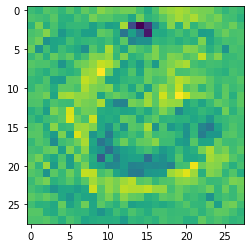

6


In [15]:
# for i in range(10):
plt.imshow(np.squeeze(x_adversarial[0] - x_train[0]))
plt.show()
print(y_train[0])

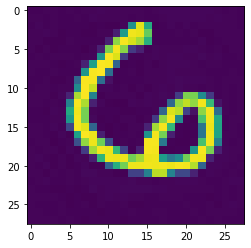

6


In [16]:
plt.imshow(np.squeeze(x_adversarial[0]))
plt.show()
print(y_train[0])

In [17]:
# %matplotlib inline
# for i in range(10):
#   plt.imshow(np.squeeze(x_adversarial[i]))
#   plt.show()
#   print(y_train[i])

Step3

In [18]:
adversarial_ds = tf.data.Dataset.from_tensor_slices(
    (x_adversarial, y_train)
).batch(100)

In [19]:
def calculate_loss(dataset, batch_size = 100):
  batch_size = 100
  loss_sum = 0.0
  for (images, labels) in adversarial_ds:
    predictions = model(images, training = True)
    loss = loss_object(labels, predictions)
    loss_sum_batch = loss * batch_size
    loss_sum = tf.add(loss_sum_batch, loss_sum)
  average_loss = tf.divide(loss_sum, 1000)
  return average_loss

In [20]:
# batch_size = 100
# loss_sum = 0.0
# for (images, labels) in adversarial_ds:
#   predictions = model(images, training = True)
#   loss = loss_object(labels, predictions)
#   loss_sum_batch = loss * batch_size
#   loss_sum = tf.add(loss_sum_batch, loss_sum)
# average_loss = tf.divide(loss_sum, 1000)

In [21]:
# def calculate_loss(dataset, batch_size = 100, additive_noise = v_array):
#   # batch_size = 100
#   loss_sum = 0.0
#   for (images, labels) in dataset:
#     predictions = model(images, training = True)
#     loss = loss_object(labels, predictions)
#     loss_sum_batch = loss * batch_size
#     loss_sum = tf.add(loss_sum_batch, loss_sum)
#   average_loss = tf.divide(loss_sum, 1000)
#   return average_loss

Step4

In [22]:
w_flat = np.ndarray([])
for w in ordinary_weights:
  w_reshape = tf.reshape(w, [-1])
  print(w_reshape.shape)
  w_flat = np.hstack([w_flat, w_reshape])
w_fro = np.linalg.norm(w_flat)
print(w_fro)
  # w_fro = tf.add(w_fro, np.linalg.norm(w_reshape, ord=2))
# w_fro = tf.sqrt(w_fro)

(288,)
(32,)
(2768896,)
(128,)
(1280,)
(10,)
16.881806112717143


In [23]:
from matplotlib.rcsetup import validate_axisbelow
eps2 = 1
eta2 = 0.1
batch_size = 100

v_updated = v_array
# vの初期値を，step2で固定したvに設定する．

for i in range(5):

  # 重みをw + (現在の)vに設定する　　ここから
  current_weights = []
  for layer_weights, v in zip(ordinary_weights, v_updated):
    current_layer_weight = tf.add(layer_weights, v)
    current_weights.append(current_layer_weight)
  model.set_weights(current_weights)
  # 重みをw + (現在の)vに設定する　　ここまで

  # gradientの計算　　ここから
  with tf.GradientTape() as tape:
    loss = calculate_loss(adversarial_ds)
    # print(loss)
  gradients = tape.gradient(loss, model.trainable_variables)
  print(gradients)
  #　計算できているし，悪い値ではない．
  # gradientの計算　　ここまで

  # gradientのノルムの計算　　ここから
  gradients_flat = np.ndarray([])
  for g in gradients:
    g_reshape = tf.reshape(g, [-1])
    gradients_flat = np.hstack([gradients_flat, g_reshape])
  gradients_norm = np.linalg.norm(gradients_flat)
  print(gradients_flat)
  print(gradients_norm)
  # ループを経るごとに値が大きくなり過ぎている？
  # gradientのノルムの計算　　ここまで

  # 勾配降下の実行　　ここから
  v_difference = []
  for g, v in zip(gradients, v_updated):
    g = tf.divide(g, gradients_norm)
    g = tf.multiply(g, w_fro)
    g = tf.multiply(eta2, g)
    v_med = tf.add(v, g)
  # 勾配降下の実行　　ここまで

  # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここから
    v_difference.append(v_med)
  v_difference_flat = np.ndarray([])
  for v_flat in v_difference:
    v_flat_reshape = tf.reshape(v_flat, [-1])
    # print(g_reshape.shape)
    v_difference_flat = np.hstack([v_difference_flat, v_flat_reshape])
  v_difference_norm = np.linalg.norm(v_difference_flat)
  # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここまで

  # 射影の実行　　ここから
  if v_difference_norm <= eps2:
    v_hat = v_med 
  else:
    v_hat = v_difference
    for v_hat_med in v_hat:
      v_hat_med = tf.multiply(v_hat_med, eps2)
      v_hat_med = tf.divide(v_hat_med, v_difference_norm)
  v_updated = v_hat
  # print(v_updated)　計算できているし，悪い値ではない．
  # 射影の実行　　ここまで

[<tf.Tensor: shape=(3, 3, 1, 32), dtype=float32, numpy=
array([[[[-8.29041004e-02, -7.17268810e-02, -6.38773739e-02,
          -7.27473572e-03, -7.44087547e-02, -8.78476650e-02,
          -2.84891371e-02, -8.23591724e-02, -8.75878558e-02,
          -5.37809636e-03, -8.45640898e-02, -6.58978820e-02,
          -1.14804931e-01, -7.20568448e-02, -1.04465351e-01,
          -1.10576242e-01, -1.28003418e-01, -4.22175638e-02,
          -4.22733021e-04, -1.37223735e-01, -5.72446883e-02,
          -1.01420528e-03, -1.08482726e-01, -1.41405687e-01,
          -4.05055238e-04, -9.62507054e-02, -5.29795662e-02,
          -1.14078424e-03, -6.53421059e-02, -3.59421819e-02,
          -3.85383107e-02, -1.17984101e-01]],

        [[-1.03901394e-01, -4.95076329e-02, -1.01441860e-01,
          -5.67853972e-02, -1.10230513e-01, -1.18439749e-01,
          -1.90265477e-02, -1.07927233e-01, -1.31122470e-01,
          -4.23708418e-03, -1.01219065e-01, -6.64197505e-02,
          -1.27941757e-01, -8.89904425e-02,

Step5

In [24]:
eta3 = 1

weights_updated = ordinary_weights
for i in range(1):

  # 重みをw + (step4で決めた)vに設定する　　ここから
  current_weights = []
  for layer_weights, v in zip(weights_updated, v_updated):
    current_layer_weight = tf.add(layer_weights, v)
    current_weights.append(current_layer_weight)
  model.set_weights(current_weights)
  print(current_weights) 
  # 計算できている．
  # 重みをw + (step4で決めた)vに設定する　　ここまで

  # # gradientの計算　　ここから
  # with tf.GradientTape() as tape:
  #   loss = calculate_loss(adversarial_ds)
  #   print(loss)
  # gradients = tape.gradient(loss, model.trainable_variables)
  # # print(gradients) 
  # # 計算できているが，値が大きい．
  # # gradientの計算　　ここまで

  # # 勾配降下の実行　　ここから
  # w_hat = []
  # for wu, g in zip(weights_updated, gradients):
  #   g_med = tf.multiply(eta3, g)
  #   wu = tf.subtract(wu, g_med)
  #   w_hat.append(wu)
  # weights_updated = w_hat
  # # 勾配降下の実行　　ここまで

[<tf.Tensor: shape=(3, 3, 1, 32), dtype=float32, numpy=
array([[[[-0.20221704, -0.12960957, -0.00191765, -0.00583333,
          -0.19998313, -0.14944239, -0.00786142, -0.13808854,
          -0.08436242, -0.14232257, -0.21263018,  0.01080207,
          -0.00664888, -0.02296855, -0.08702486, -0.10009864,
          -0.12552516, -0.10157504, -0.01926671, -0.01691149,
          -0.05881771, -0.08036529, -0.10039019, -0.05076125,
          -0.05155951, -0.04987686, -0.15322872, -0.10649565,
          -0.11289763, -0.11050452, -0.07169203, -0.00511815]],

        [[-0.0348689 ,  0.03241329, -0.15076567, -0.09466611,
          -0.02082111, -0.15694177, -0.05890032, -0.05429192,
          -0.07913763, -0.12887354,  0.02438363, -0.17263174,
           0.00927196, -0.14292635, -0.07704648, -0.09912122,
           0.00195159, -0.12023157, -0.09563363, -0.124596  ,
           0.08223294, -0.11662102, -0.08487256, -0.03389651,
          -0.01610883, -0.15304987,  0.00878952, -0.00255135,
          -

再テストの実行

In [25]:
EPOCHS = 5

for epoch in range(EPOCHS):
    test_loss.reset_states()
    test_accuracy.reset_states()

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Test Loss: 2.3221755027770996, Test Accuracy: 6.039999961853027
Epoch 2, Test Loss: 2.3221755027770996, Test Accuracy: 6.039999961853027
Epoch 3, Test Loss: 2.3221755027770996, Test Accuracy: 6.039999961853027
Epoch 4, Test Loss: 2.3221755027770996, Test Accuracy: 6.039999961853027
Epoch 5, Test Loss: 2.3221755027770996, Test Accuracy: 6.039999961853027
